In [59]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

import TwoPUtils as tpu

%matplotlib inline

In [2]:
rng = np.random.default_rng()



In [14]:
w = rng.random(size=[100,100]) # feedforward weights
# w = rng.standard_gamma(1, size = [100,100])
# w = rng.chisquare(1, size = [100,100])
# w = rng.lognormal( sigma = 1, size = [100,100])

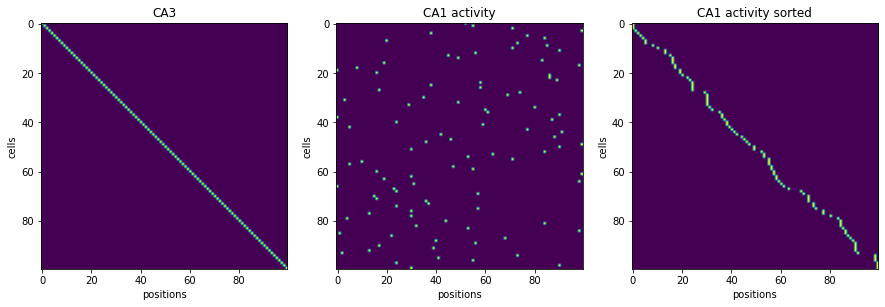

In [15]:
ca3 = np.eye(100)
ca1 = np.zeros([100,100]) # cells x positions
activation = np.matmul(w.T,ca3) # activation
winners = np.argmax(activation,axis=0) # WTA

ca1[np.arange(0,100),winners]=1

fig, ax = plt.subplots(1,3, figsize=[15, 5])
ax[0].imshow(ca3)
ax[0].set_title('CA3')

ax[1].imshow(ca1)

ca1_sort = np.argsort(np.argmax(ca1,axis=-1))
ax[2].imshow(ca1[ca1_sort,:])

ax[1].set_title('CA1 activity')
ax[2].set_title('CA1 activity sorted')

for i in range(3):
    ax[i].set_ylabel('cells')
    ax[i].set_xlabel('positions')
    

(1000, 1000)


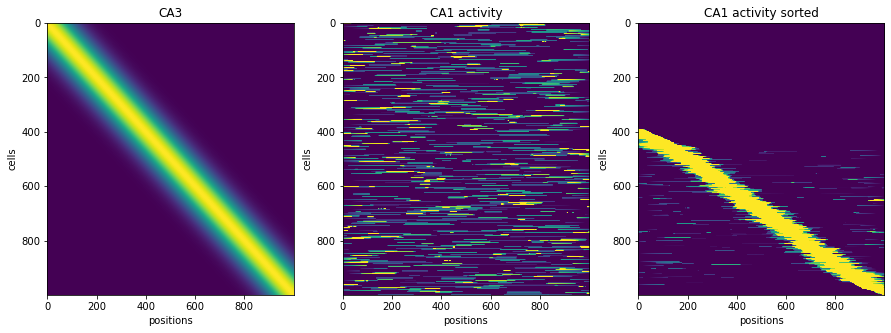

In [81]:
# repeat with radial basis funcitons
npos = 1000
pos = np.linspace(0,10,num=npos)[np.newaxis,:]


n_ca3=1000
n_ca1=1000
n_winners = 100

mu = np.linspace(0,10,num=n_ca3)[:,np.newaxis]
ca3  = tpu.utilities.gaussian(mu,1,pos) # cells by postions

w = rng.lognormal(sigma=.5, size= [n_ca1,n_ca3])
# w = rng.random(size= [n_ca1,n_ca3])

activations = np.matmul(w,ca3) 
winners = np.argmax(activations,axis=0)
# winners = np.
winners = np.argsort(activations,axis=0)[::-1,:]
print(winners.shape)

ca1 = np.zeros([n_ca1,npos])
for i in range(npos):
    ca1[winners[:n_winners,i],i]=activations[winners[:n_winners,i],i]
# print(ca3.sum(axis=-1))

ca1_z = (ca1-ca1.mean(axis=-1,keepdims=True))/(np.std(ca1,axis=-1,keepdims=True)+1E-3)
fig, ax = plt.subplots(1,3, figsize=[15, 5])
ax[0].imshow(ca3, vmin=0,vmax=1, aspect='auto')
ax[0].set_title('CA3')

ax[1].imshow(ca1_z, vmin=0,vmax=1, aspect='auto')

ca1_sort = np.argsort(np.argmax(ca1,axis=-1))
ax[2].imshow(ca1_z[ca1_sort,:], vmin=0,vmax=1,aspect='auto')

ax[1].set_title('CA1 activity')
ax[2].set_title('CA1 activity sorted')

for i in range(3):
    ax[i].set_ylabel('cells')
    ax[i].set_xlabel('positions')


In [ ]:
# add learning with a gain parameter

# uniform gain parameter vs 0 gain

# gain parameter depends on proximity to reward - aka dopamine

# homeostatic plasticity

# look for prediction of more out of field firing in the absence of LTP

# ask for example entorhinal 

# prediction that CA3 inactivated animals won't over represent reward?


In [67]:
a= np.arange(0,10)
print(np.argsort(a))

[0 1 2 3 4 5 6 7 8 9]
